In [1]:
import os
import sys
sys.path.append('/Users/wangqiqian/Desktop/TrafficTDApython/')

current_dir_path = os.getcwd()
current_file_path = os.path.abspath(current_dir_path)
current_dir_path = os.path.dirname(current_file_path)
parent_dir_path = os.path.dirname(current_dir_path)

# os.chdir(current_dir_path + '\\ultils')
os.chdir(current_dir_path + '/ultils')
print(current_dir_path)

import time
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import AgglomerativeClustering

from functions import *
from chi import *
from regressionP import *
from models import *
from utils_v3 import *

os.chdir('/Users/wangqiqian/Desktop/TrafficTDApython/')
# os.chdir('C:/Users/USER/Desktop/TrafficTDApython/')

from Version3.tdamapper.core import MapperAlgorithm
from Version3.tdamapper.cover import CubicalCover
from Version3.tdamapper.clustering import FailSafeClustering
from Version3.tdamapper.plot import MapperLayoutInteractive

/Users/wangqiqian/Desktop/TrafficTDApython


In [2]:
data1 = pd.read_csv("Data/NPA_TMA2_1.csv", low_memory=False)[:-2]
data2 = pd.read_csv("Data/NPA_TMA2_2.csv", low_memory=False)[:-2]
data3 = pd.read_csv("Data/NPA_TMA2_3.csv", low_memory=False)[:-2]
data4 = pd.read_csv("Data/NPA_TMA2_4_new.csv", low_memory=False)[:-2]
data5 = pd.read_csv("Data/NPA_TMA2_5.csv", low_memory=False)[:-2]
data6 = pd.read_csv("Data/NPA_TMA2_6_new.csv", low_memory=False)[:-2]
data7 = pd.read_csv("Data/NPA_TMA2_7.csv", low_memory=False)[:-2]
data8 = pd.read_csv("Data/NPA_TMA2_8.csv", low_memory=False)[:-2]
data9 = pd.read_csv("Data/NPA_TMA2_9.csv", low_memory=False)[:-2]
data10 = pd.read_csv("Data/NPA_TMA2_10.csv", low_memory=False)[:-2]

dataA2 = pd.concat([data1, data2, data3, data4, data5, data6, data7, data8, data9, data10], ignore_index=True)
# dataA2 = pd.concat([data1, data2, data3, data4, data5], ignore_index=True)

dataA1 = pd.read_csv("Data/NPA_TMA1_V3.csv")[:-2]

In [3]:
dataA1.columns

Index(['發生年度', '發生月份', '發生日期', '發生時間', '事故類別名稱', '處理單位名稱警局層', '發生地點', '天候名稱',
       '光線名稱', '道路類別-第1當事者-名稱', '速限-第1當事者', '道路型態大類別名稱', '道路型態子類別名稱',
       '事故位置大類別名稱', '事故位置子類別名稱', '路面狀況-路面鋪裝名稱', '路面狀況-路面狀態名稱', '路面狀況-路面缺陷名稱',
       '道路障礙-障礙物名稱', '道路障礙-視距品質名稱', '道路障礙-視距名稱', '號誌-號誌種類名稱', '號誌-號誌動作名稱',
       '車道劃分設施-分向設施大類別名稱', '車道劃分設施-分向設施子類別名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱',
       '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱', '事故類型及型態大類別名稱',
       '事故類型及型態子類別名稱', '肇因研判大類別名稱-主要', '肇因研判子類別名稱-主要', '死亡受傷人數', '當事者順位',
       '當事者區分-類別-大類別名稱-車種', '當事者區分-類別-子類別名稱-車種', '當事者屬-性-別名稱', '當事者事故發生時年齡',
       '保護裝備名稱', '行動電話或電腦或其他相類功能裝置名稱', '當事者行動狀態大類別名稱', '當事者行動狀態子類別名稱',
       '車輛撞擊部位大類別名稱-最初', '車輛撞擊部位子類別名稱-最初', '車輛撞擊部位大類別名稱-其他', '車輛撞擊部位子類別名稱-其他',
       '肇因研判大類別名稱-個別', '肇因研判子類別名稱-個別', '肇事逃逸類別名稱-是否肇逃', '經度', '緯度'],
      dtype='object')

In [3]:
select_lst = [
    '道路類別-第1當事者-名稱', '速限-第1當事者', '道路型態大類別名稱', '道路型態子類別名稱',
    '事故位置大類別名稱', '事故位置子類別名稱', '路面狀況-路面鋪裝名稱', '路面狀況-路面狀態名稱', '路面狀況-路面缺陷名稱',
    '道路障礙-障礙物名稱', '道路障礙-視距品質名稱', '道路障礙-視距名稱', '號誌-號誌種類名稱', '號誌-號誌動作名稱',
    '車道劃分設施-分向設施大類別名稱', '車道劃分設施-分向設施子類別名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱',
    '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱', '事故類型及型態大類別名稱',
    '事故類型及型態子類別名稱', '死亡受傷人數',
    '肇因研判子類別名稱-個別'
    # '經度', '緯度'
]
print(len(select_lst))

def preprocess(input_data, select_lst):
    
    sample_data = input_data[input_data['當事者順位'] == 1].reset_index(drop=True, inplace=False)
    sample_data = sample_data[sample_data['發生月份'] < 3]
    dataA = sample_data[select_lst]
    
    # 將資料分出死亡和受傷，合併到原本的資料後去除多餘的死亡受傷人數
    death_injury_data = split_death_injury(dataA['死亡受傷人數'])
    dist_df = pd.concat([dataA, death_injury_data], axis=1)
    dist_df.drop(columns=['死亡受傷人數'], inplace=True)
    
    return dist_df

dist_dfA1 = preprocess(dataA1, select_lst)
dist_dfA2 = preprocess(dataA2, select_lst)
# Concat
rbind_data = pd.concat([dist_dfA1, dist_dfA2], axis=0, ignore_index=True)
assert rbind_data.shape[0] == dist_dfA1.shape[0] + dist_dfA2.shape[0]
# Dummy
rbind_data["速限-第1當事者"] = rbind_data["速限-第1當事者"].astype(str)
dummy_data = pd.get_dummies(rbind_data)

print(dummy_data.shape)

data_to_map = dummy_data.drop(['死亡', '受傷'], axis=1)
mapper_numpy = data_to_map.to_numpy()

23
(65306, 293)


### Multiple correspondence analysis (MCA)
多重對應分析是專門針對dummy來進行降維的，所以使用它作為主要方法沒有問題

In [4]:
import prince

# The input of MCA no need to use dummy_data
MCA_X = rbind_data.drop(['死亡', '受傷'], axis=1)

mca = prince.MCA(
    one_hot=True,
    n_components=7,
    n_iter=30,
    copy=True,
    check_input=True,
    random_state=42
)

mca.fit(MCA_X)
lens = mca.transform(MCA_X)

print(mca.eigenvalues_summary)
# mca.column_contributions_.head().style.format('{:.0%}')

          eigenvalue % of variance % of variance (cumulative)
component                                                    
0              0.260         2.12%                      2.12%
1              0.165         1.35%                      3.47%
2              0.144         1.17%                      4.64%
3              0.129         1.05%                      5.69%
4              0.118         0.96%                      6.66%
5              0.109         0.89%                      7.55%
6              0.100         0.82%                      8.37%


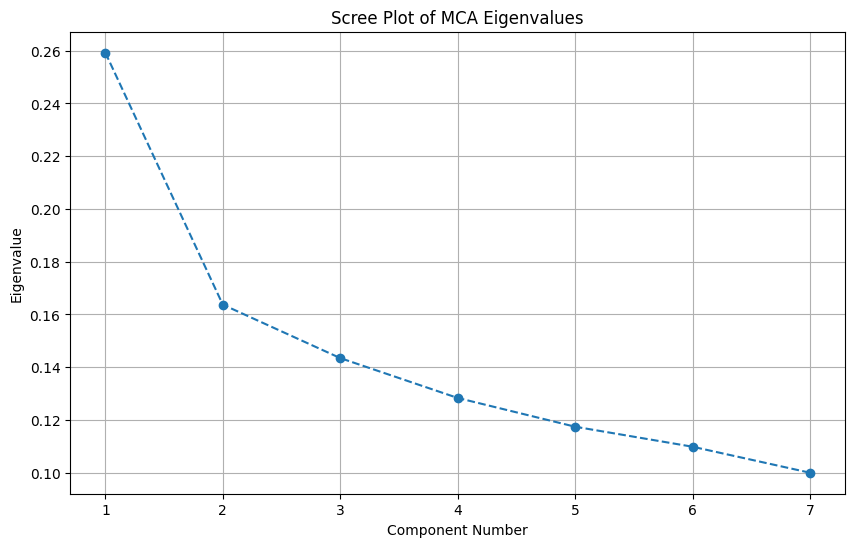

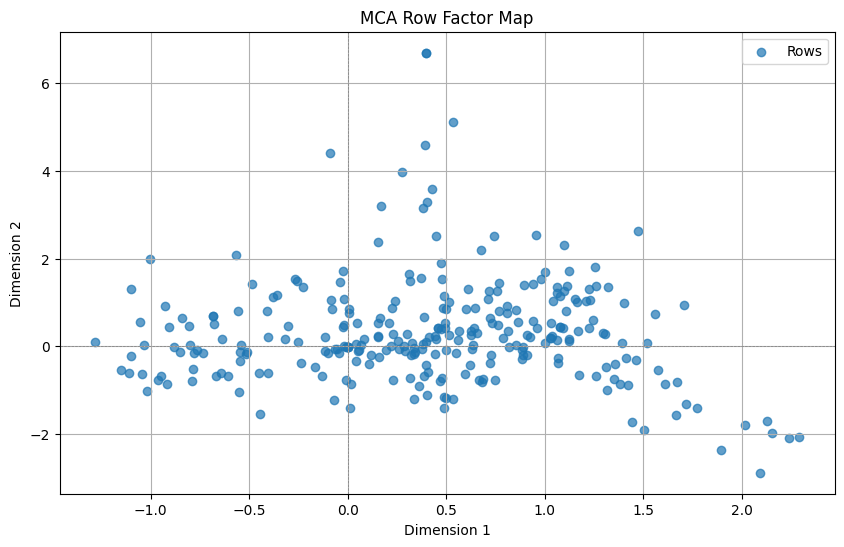

In [5]:
import matplotlib.pyplot as plt

# Generate the scree plot for MCA eigenvalues
eigenvalues = mca.eigenvalues_

# Plot the eigenvalues to show the variance explained by each component
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, marker='o', linestyle='--')
plt.title("Scree Plot of MCA Eigenvalues")
plt.xlabel("Component Number")
plt.ylabel("Eigenvalue")
plt.xticks(range(1, len(eigenvalues) + 1))
plt.grid(True)
plt.show()

# Generate MCA row/column factor map
# coordinates = mca.row_coordinates(MCA_X)
col_coordinate = mca.column_coordinates(MCA_X)
plt.figure(figsize=(10, 6))
plt.scatter(col_coordinate[0], col_coordinate[1], alpha=0.7, label="Rows")

# Label the plot
plt.axhline(0, color='grey', linestyle='--', linewidth=0.5)
plt.axvline(0, color='grey', linestyle='--', linewidth=0.5)
plt.title("MCA Row Factor Map")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)
plt.legend()
plt.show()

# Find the best mapper

Best interval for overlap=3: 9
Best interval for overlap=4: 7
Best interval for overlap=5: 8

In [ ]:
detailed_results = []

for overlap in range(3, 6):
    silhouette_for_intervals = []

    for interval in range(5, 11):

        print(f'overlap: {overlap}, interval: {interval}')
        mapper_algo = MapperAlgorithm(
            cover=CubicalCover(
                n_intervals=interval,
                overlap_frac=overlap / 10
            ),
            clustering=AgglomerativeClustering(linkage='single')
        )

        mapper_info = mapper_algo.fit_transform(mapper_numpy, lens)
        silhouette_for_intervals.append(mapper_info[1])

        detailed_results.append({
            "overlap": overlap,
            "interval": interval,
            "silhouette": mapper_info[1],
            "mapper_info": mapper_info
        })
 
    best_interval = np.argmax(silhouette_for_intervals) + 5  # +5 因為 interval 從5開始

    print(silhouette_for_intervals)
    print(f"Best interval for overlap={overlap}: {best_interval}")

In [17]:
mapper_algo = MapperAlgorithm(
    cover=CubicalCover(
        n_intervals=8,
        overlap_frac=4 / 10
    ),
    clustering=FailSafeClustering(
        AgglomerativeClustering(linkage='single')
    )
)

mapper_info = mapper_algo.fit_transform(mapper_numpy, lens)

Processing Clusters:  60%|█████▉    | 245/411 [02:21<00:44,  3.72it/s]11/29/2024 03:30:28 PM core WARNING: Unable to perform clustering on local chart: Found array with 1 sample(s) (shape=(1, 291)) while a minimum of 2 is required by AgglomerativeClustering.
11/29/2024 03:30:29 PM core WARNING: Unable to perform clustering on local chart: Found array with 1 sample(s) (shape=(1, 291)) while a minimum of 2 is required by AgglomerativeClustering.
11/29/2024 03:30:29 PM core WARNING: Unable to perform clustering on local chart: Found array with 1 sample(s) (shape=(1, 291)) while a minimum of 2 is required by AgglomerativeClustering.
Processing Clusters:  68%|██████▊   | 280/411 [02:34<00:49,  2.66it/s]11/29/2024 03:30:41 PM core WARNING: Unable to perform clustering on local chart: Found array with 1 sample(s) (shape=(1, 291)) while a minimum of 2 is required by AgglomerativeClustering.
11/29/2024 03:30:42 PM core WARNING: Unable to perform clustering on local chart: Found array with 1 sam

In [8]:
# detailed_results_df = pd.DataFrame(detailed_results)
# detailed_results_df.to_csv("/Users/wangqiqian/Desktop/TrafficTDApython/Version3/GridSearch/full_grid.csv", index=False)

# output_file = '/Users/wangqiqian/Desktop/TrafficTDApython/Version3/GridSearch/full_grid_single.pkl'
# with open(output_file, 'wb') as f:
#     pickle.dump(detailed_results_df, f)

# print(f"Results saved to {output_file}")

In [7]:
with open('/Users/wangqiqian/Desktop/TrafficTDApython/Version3/GridSearch/full_grid_single.pkl', 'rb') as f:
    detailed_results_df = pickle.load(f)

detailed_results_df = detailed_results_df.sort_values(by='silhouette')
detailed_results_df

,overlap,interval,silhouette,mapper_info
4,3,9,-0.056763,"((149, 1, 182, 661, 904, 3, 287, 467, 878, 116..."
5,3,10,-0.052250,"((1, 36, 2, 4, 8, 214, 6, 124, 1217, 312, 375,..."
2,3,7,-0.032888,"((0, 26, 2, 74, 88, 185, 330, 334, 505, 4, 6, ..."
10,4,9,-0.018857,"((0, 114, 428, 2, 64, 412, 491, 579, 4, 410, 6..."
17,5,10,-0.016858,"((0, 30, 606, 2, 48, 70, 104, 270, 358, 4, 8, ..."
16,5,9,-0.012943,"((0, 80, 287, 2, 89, 275, 318, 4, 14, 30, 269,..."
11,4,10,-0.005995,"((0, 34, 2, 118, 235, 402, 535, 552, 571, 613,..."
3,3,8,-0.003306,"((0, 960, 2, 156, 458, 4, 22, 50, 68, 277, 303..."
8,4,7,0.009832,"((0, 2, 30, 89, 109, 123, 137, 226, 255, 285, ..."
1,3,6,0.024868,"((0, 80, 2, 4, 114, 6, 438, 8, 16, 28, 58, 108..."


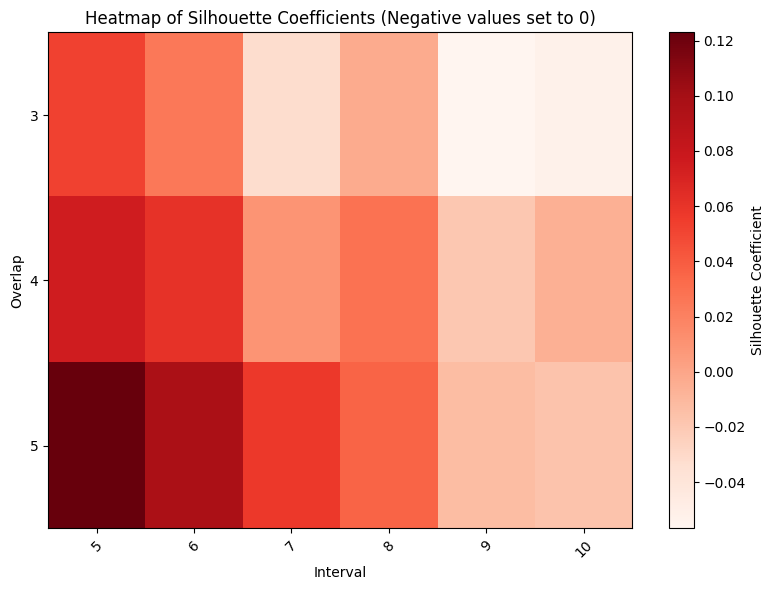

In [37]:
matrix = detailed_results_df.pivot_table(index="overlap", columns="interval", values="silhouette")
# matrix[matrix < 0] = 0

plt.figure(figsize=(8, 6))
plt.imshow(matrix, cmap='Reds', aspect='auto', interpolation='nearest')
plt.colorbar(label='Silhouette Coefficient')
plt.xticks(range(len(matrix.columns)), matrix.columns, rotation=45)
plt.yticks(range(len(matrix.index)), matrix.index)
plt.xlabel('Interval')
plt.ylabel('Overlap')
plt.title('Heatmap of Silhouette Coefficients (Negative values set to 0)')
plt.tight_layout()
plt.show()

# Testing for params

10 overlap=4, interval=8 <br/>
3: overlap=4, interval=9 <br/>
6: overlap=4, interval=10

In [18]:
mapper_plot1 = MapperLayoutInteractive(
    # detailed_results_df['mapper_info'].iloc[10][0],
    mapper_info[0],
    colors = rbind_data['死亡'].to_numpy(),
    # colors=rbind_data['肇因研判子類別名稱-個別'].to_numpy(),
    cmap = 'jet',
    agg = average_encoded_label,
    # agg = most_common_encoded_label,
    dim = 3,
    iterations = 50,
    seed = 10,
    width = 800,
    height = 800)

fig_mean1 = mapper_plot1.plot()
fig_mean1.show(config={'scrollZoom': True})

In [ ]:
# mapper_plot1.update(
#     colors=rbind_data['死亡'].to_numpy(),
#     cmap = 'jet', 
#     agg=average_encoded_label,
#     # agg = most_common_encoded_label
# )

# fig_std = mapper_plot1.plot()
# fig_std.show(config={'scrollZoom': True})

## Get data info

In [20]:
x = vars(mapper_plot1._MapperLayoutInteractive__fig)['_data_objs'][1]['x']
y = vars(mapper_plot1._MapperLayoutInteractive__fig)['_data_objs'][1]['y']
z = vars(mapper_plot1._MapperLayoutInteractive__fig)['_data_objs'][1]['z']

threeDimData = pd.DataFrame({'x': x, 'y': y, 'z': z})

import re
data_tuple = vars(mapper_plot1._MapperLayoutInteractive__fig)['_data_objs'][1]['text']

data = []
for item in data_tuple:
    # color = int(re.search(r'color: (-?\d+)', item).group(1))
    color = float(re.search(r'color: ([\d.]+)', item).group(1))
    node = int(re.search(r'node: (\d+)', item).group(1))
    size = int(re.search(r'size: (\d+)', item).group(1))
    data.append({'color': color, 'node': node, 'size': size})
component_info = pd.DataFrame(data)

full_info = pd.concat([component_info, threeDimData], axis=1)

mp_content_origin = vars(mapper_plot1._MapperLayoutInteractive__graph)['_node']

mp_content = pd.DataFrame.from_dict(mp_content_origin, orient='index')
mp_content.reset_index(inplace=True)
mp_content.rename(columns={'index': 'node'}, inplace=True)

full_info = pd.merge(full_info, mp_content, on=['node', 'size'], how='inner')

### Fit model

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

11/29/2024 03:45:11 PM legend WARNING: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


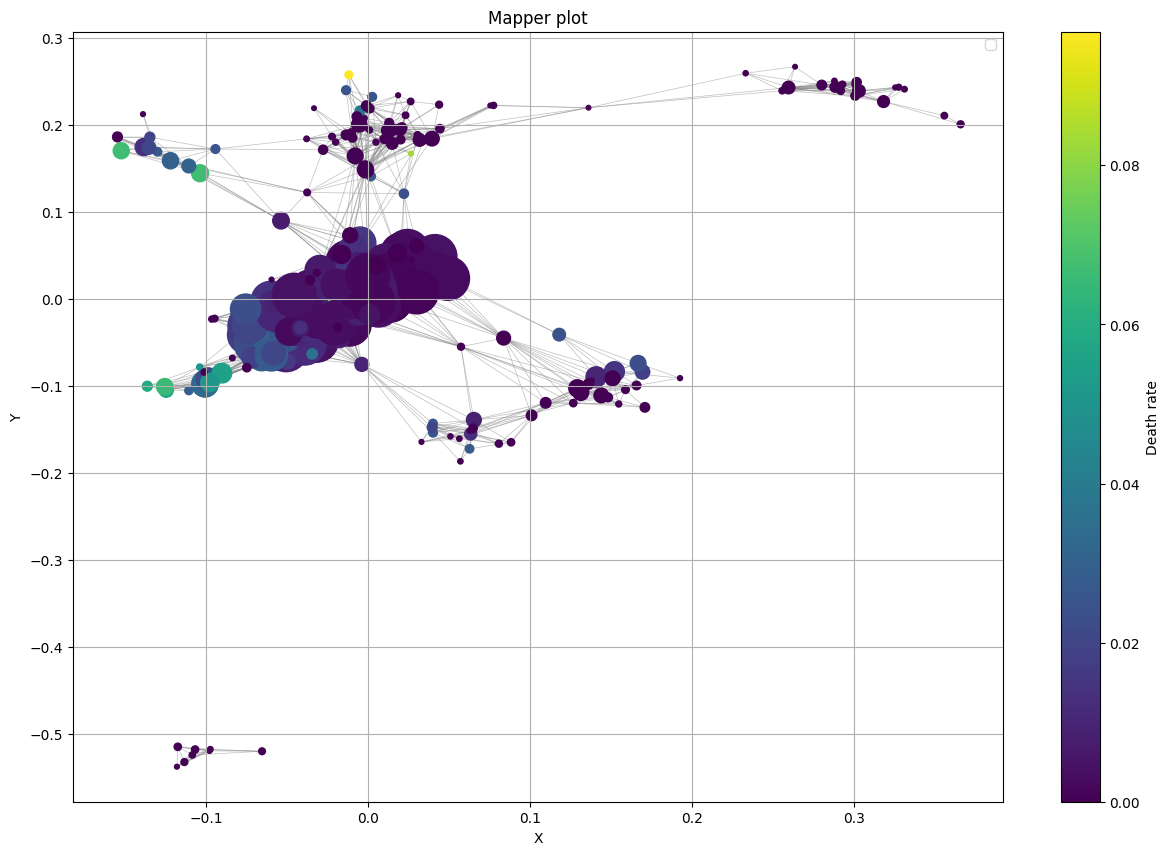

In [22]:
df = full_info[(full_info['size'] > 10)]
clipped_size = np.clip(df['size'], None, 1000)

graph = vars(mapper_plot1._MapperLayoutInteractive__graph)
edges = graph['edges']

node_positions = {row['node']: (row['x'], row['z']) for _, row in df.iterrows()}

X = df['x'].values.reshape(-1, 1)
y = df['y'].values.reshape(-1, 1)

plt.figure(figsize=(15, 10))
scatter = plt.scatter(df['x'], df['z'], c=df['color'], cmap='viridis', s=clipped_size, marker='o')

for edge in edges:
    if edge[0] in node_positions and edge[1] in node_positions:
        x_coords = [node_positions[edge[0]][0], node_positions[edge[1]][0]]
        y_coords = [node_positions[edge[0]][1], node_positions[edge[1]][1]]
        plt.plot(x_coords, y_coords, color='grey', alpha=0.5, linewidth=0.5, zorder=0)

colorbar = plt.colorbar(scatter)
colorbar.set_label('Death rate')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Mapper plot')

plt.legend()
plt.grid(True)
plt.show()

# 最高輪廓係數的圖像
多個圖像都有一個共通點，那就是一個主要的中心以及向外分岔的資料點

11/29/2024 11:42:42 AM legend WARNING: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


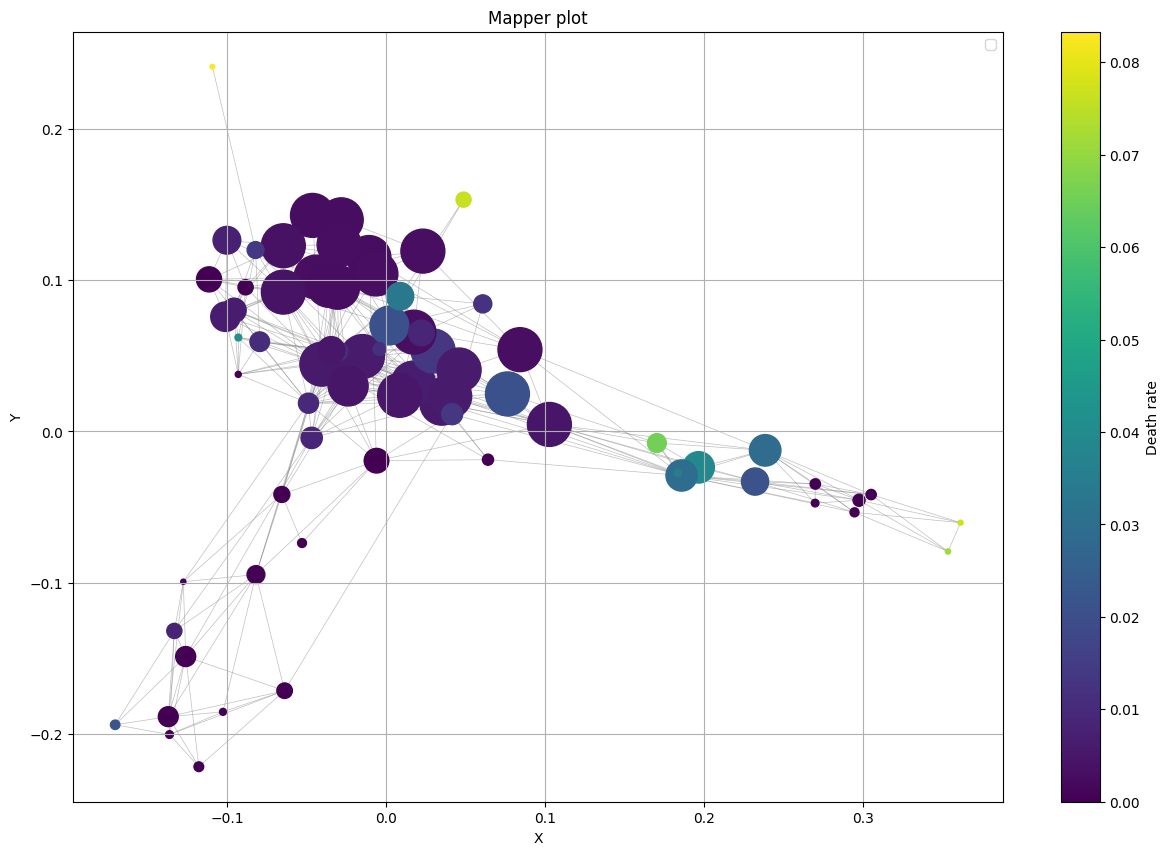

In [34]:
df = full_info[(full_info['size'] > 10)]
clipped_size = np.clip(df['size'], None, 1000)

graph = vars(mapper_plot1._MapperLayoutInteractive__graph)
edges = graph['edges']

node_positions = {row['node']: (row['x'], row['y']) for _, row in df.iterrows()}

X = df['x'].values.reshape(-1, 1)
y = df['y'].values.reshape(-1, 1)

degree = 3
poly = PolynomialFeatures(degree)
X_poly = poly.fit_transform(X)
model = LinearRegression()
model.fit(X_poly, y)

x_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
x_range_poly = poly.transform(x_range)
y_pred = model.predict(x_range_poly)

plt.figure(figsize=(15, 10))
scatter = plt.scatter(df['x'], df['y'], c=df['color'], cmap='viridis', s=clipped_size, marker='o')

# plt.plot(x_range, y_pred, color='red', label=f'Polynomial Fit (degree={degree})')

for edge in edges:
    if edge[0] in node_positions and edge[1] in node_positions:
        x_coords = [node_positions[edge[0]][0], node_positions[edge[1]][0]]
        y_coords = [node_positions[edge[0]][1], node_positions[edge[1]][1]]
        plt.plot(x_coords, y_coords, color='grey', alpha=0.5, linewidth=0.5, zorder=0)

colorbar = plt.colorbar(scatter)
colorbar.set_label('Death rate')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Mapper plot')

plt.legend()
plt.grid(True)
plt.show()

In [ ]:
calinski_data = get_calinski_from_db(full_info, 0.006)
labels = calinski_data[3]
db = calinski_data[2]
n_clusters_ = calinski_data[4]

print(n_clusters_)

do_plot(full_info, calinski_data, labels, db, n_clusters_)

label_0 = full_info[full_info['label'] == 0]
label_1 = full_info[full_info['label'] == 1]
label_out = full_info[(full_info['label'] != 1) & (full_info['label'] != 0)]

count_0 = get_count_dict(label_0)
count_1 = get_count_dict(label_1)
count_out = get_count_dict(label_out)
full_0 = rbind_data.loc[count_0.keys()]
full_1 = rbind_data.loc[count_1.keys()]
full_out = rbind_data.loc[count_out.keys()]
# 重疊
lst01 = list(count_0.keys() & count_1.keys())
full_01 = full_0.loc[lst01]

full_0 = full_0.drop(lst01)
full_1 = full_1.drop(lst01)

# print('01連接點數量', len(lst01))

full_01.shape[0] + full_0.shape[0] + full_1.shape[0] == rbind_data.shape[0]

In [ ]:
# fig_mean1 = mapper_plot1.plot()
# fig_mean1.show(config={'scrollZoom': True})

In [ ]:
def get_specific_cluster(label):
    
    label_data = full_info[full_info['label'] == label]
    count = get_count_dict(label_data)
    full = rbind_data.loc[count.keys()]
    return full

for i in range(7):
    
    specific_data = get_specific_cluster(i)

    print(specific_data['死亡'].value_counts(normalize = True))

## Chi test

In [ ]:
# full_1#.drop(['緯度'], axis=1)

In [ ]:
result = compare_categorical_features(full_0.drop(['緯度', '經度', '速限-第1當事者'], axis=1), 
                                      full_1.drop(['緯度', '經度', '速限-第1當事者'], axis=1))
result.sort_values(by="chi2", ascending=False)

## 四分位圖

In [ ]:
# latitude_data_full_0 = full_0['經度']
# latitude_data_full_1 = full_1['經度']

# # 繪製四分位圖
# plt.figure(figsize=(10, 6))
# plt.boxplot([latitude_data_full_0, latitude_data_full_1], labels=['full_0', 'full_1'])
# plt.title('緯度的四分位圖')
# plt.ylabel('緯度')
# plt.grid(True)
# plt.show()

## 計數圖

In [ ]:
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei'] # Window
# plt.rcParams['font.sans-serif']=['Arial Unicode Ms'] # Mac
plt.rcParams['axes.unicode_minus'] = False

injury_distribution = pd.DataFrame({
    'full_0': full_0['號誌-號誌動作名稱'].value_counts(normalize=True),
    'full_1': full_1['號誌-號誌動作名稱'].value_counts(normalize=True)
})

print(injury_distribution)

# 可視化分布差異
injury_distribution.plot(kind='bar', figsize=(10, 6))
plt.title('distribution')
plt.xlabel('injured state')
plt.ylabel('ratio')
plt.show()

## Pickle save

In [ ]:
# import pickle

# with open('../Version3/GridSearch/全部mapper資料.pkl', 'wb') as f:
#     pickle.dump(results, f)

# Example parameters

1. 以圖像為例，較高的interval(10)配上較高的overlap(0.65)有較直觀的效果，而使用clustering方法設為10的華德法也較好，同時範例將PCA設為2。[連結](https://pypi.org/project/tda-mapper/0.2.0/)
2. 但是將PCA調高雖然增加計算量，但是也在interval不設置大麼多的情況下得到好的結果
3. 設置高的clsustering數量可以得出較好的捕捉局部資料lens = PCA(2).fit_transform(X)

In [ ]:
from sklearn.datasets import load_digits

X, y = load_digits(return_X_y=True) 

pca = PCA(n_components=2)
lens = pca.fit_transform(X)

explained_variance_ratio  = pca.explained_variance_ratio_
print(sum(explained_variance_ratio))
print(explained_variance_ratio)

In [ ]:
# mapper_algo = MapperAlgorithm(
#     cover=CubicalCover(
#         n_intervals=10,
#         overlap_frac=0.65),
#     clustering = FailSafeClustering(
#         clustering = AgglomerativeClustering(10, linkage='ward'),
#         verbose = False)
# )
# mapper_graph = mapper_algo.fit_transform(X, lens)

# mapper_plot = MapperLayoutInteractive(
#     mapper_graph,
#     colors=y,                       
#     cmap='jet',
#     agg=np.nanmean,
#     dim=3,
#     iterations=400,
#     seed=42,
#     title='digit (mean)',
#     width=600,
#     height=600)

# fig_mean1 = mapper_plot.plot()
# fig_mean1.show(config={'scrollZoom': True})